In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/commit-record/final_dataset.csv


<h1> IMPORTING ALL MAJOR LIBRARIES</h1>


In [2]:
#loading the important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from termcolor import colored
import itertools
import re
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)


In [3]:
#setting up the seed and the environment
import os
import random
import numpy as np
import tensorflow as tf


seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2025-09-03 04:43:04.851140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756874585.081544      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756874585.155330      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h1> Lets view the data</h1>

In [4]:


def describe_data(data):
    print(colored("📐 DATA OVERVIEW", "cyan", attrs=["bold"]))
    print(colored(f"🔹 Shape: {data.shape[0]} rows × {data.shape[1]} columns", "green"))

    # Column Names
    print("\n" + colored("📋 Column Names:", "yellow", attrs=["bold"]))
    for col in data.columns.tolist():
        print(f"   • {col}")

    # Data Types
    print("\n" + colored("🔎 Data Types:", "yellow", attrs=["bold"]))
    dtypes_df = data.dtypes.reset_index()
    dtypes_df.columns = ["Column", "Type"]
    print(tabulate(dtypes_df, headers="keys", tablefmt="fancy_grid"))

    # Numerical Columns
    num_cols = data.select_dtypes(include="number").columns.tolist()
    print("\n" + colored("Numerical Columns:", "yellow", attrs=["bold"]))
    print(num_cols if num_cols else "None")

    # Categorical Columns
    cat_cols = data.select_dtypes(include="object").columns.tolist()
    print("\n" + colored(" Categorical Columns:", "yellow", attrs=["bold"]))
    print(cat_cols if cat_cols else "None")

    # Random Sample
    print("\n" + colored("🎲 Random 5 Rows:", "yellow", attrs=["bold"]))
    print(data.sample(5))

    # Missing Values
    missing_values = data.isnull().sum()
    missing_df = missing_values.reset_index()
    missing_df.columns = ["Column", "Missing Values"]
    print("\n" + colored("⚠️ Missing Values:", "red", attrs=["bold"]))
    print(tabulate(missing_df, headers="keys", tablefmt="fancy_grid"))


In [5]:


def analyse_column(data):
    # Categorical Columns (only with < 10 unique values)
    categorical_columns = data.select_dtypes(include="object").columns.tolist()
    print(colored(" CATEGORICAL COLUMNS (Unique < 10)", "cyan", attrs=["bold"]))
    for col in categorical_columns:
        if data[col].nunique() < 10:   
            print(colored(f"\n▶ Column: {col}", "yellow", attrs=["bold"]))
            vc = data[col].value_counts().reset_index()
            vc.columns = ["Category", "Count"]
            print(tabulate(vc, headers="keys", tablefmt="fancy_grid"))

    # Numerical Summary
    print("\n" + colored("🔢 NUMERICAL SUMMARY", "cyan", attrs=["bold"]))
    desc = data.describe().reset_index()
    print(tabulate(desc, headers="keys", tablefmt="fancy_grid"))


In [6]:
data = pd.read_csv("/kaggle/input/commit-record/final_dataset.csv")


<h3>Handling date and time</h3>

In [7]:
#we take out the day and the hour separately
data['day'] = data['timeofcommit'].str.split(' ').str[0]
data['hour'] = data['timeofcommit'].str.split(' ').str[1].str.split(':').str[0].astype(int)
data  = data.drop('timeofcommit', axis = 1)

In [8]:
describe_data(data)

📐 DATA OVERVIEW
🔹 Shape: 1500 rows × 11 columns

📋 Column Names:
   • index
   • role
   • committype
   • fileextensions
   • numfileschanged
   • linesadded
   • linesdeleted
   • numcommentsadded
   • commitmessage
   • day
   • hour

🔎 Data Types:
╒════╤══════════════════╤════════╕
│    │ Column           │ Type   │
╞════╪══════════════════╪════════╡
│  0 │ index            │ int64  │
├────┼──────────────────┼────────┤
│  1 │ role             │ object │
├────┼──────────────────┼────────┤
│  2 │ committype       │ object │
├────┼──────────────────┼────────┤
│  3 │ fileextensions   │ object │
├────┼──────────────────┼────────┤
│  4 │ numfileschanged  │ int64  │
├────┼──────────────────┼────────┤
│  5 │ linesadded       │ int64  │
├────┼──────────────────┼────────┤
│  6 │ linesdeleted     │ int64  │
├────┼──────────────────┼────────┤
│  7 │ numcommentsadded │ int64  │
├────┼──────────────────┼────────┤
│  8 │ commitmessage    │ object │
├────┼──────────────────┼────────┤
│  9 │ day   

In [9]:
analyse_column(data)

 CATEGORICAL COLUMNS (Unique < 10)

▶ Column: role
╒════╤════════════╤═════════╕
│    │ Category   │   Count │
╞════╪════════════╪═════════╡
│  0 │ backend    │     484 │
├────┼────────────┼─────────┤
│  1 │ frontend   │     444 │
├────┼────────────┼─────────┤
│  2 │ qa         │     313 │
├────┼────────────┼─────────┤
│  3 │ fullstack  │     259 │
╘════╧════════════╧═════════╛

▶ Column: committype
╒════╤════════════╤═════════╕
│    │ Category   │   Count │
╞════╪════════════╪═════════╡
│  0 │ feature    │     596 │
├────┼────────────┼─────────┤
│  1 │ bugfix     │     421 │
├────┼────────────┼─────────┤
│  2 │ test       │     279 │
├────┼────────────┼─────────┤
│  3 │ refactor   │     204 │
╘════╧════════════╧═════════╛

▶ Column: day
╒════╤════════════╤═════════╕
│    │ Category   │   Count │
╞════╪════════════╪═════════╡
│  0 │ Friday     │     289 │
├────┼────────────┼─────────┤
│  1 │ Thursday   │     227 │
├────┼────────────┼─────────┤
│  2 │ Tuesday    │     224 │
├────┼──────

<h4> The data seems decently balanced so we need not to remove or add anything</h4>

<h1> Univaritate analysis</h1>

In [10]:

#function to plot all the numerical columns hisplots and boxplot
def numerical_plots(data):
    numeric_cols = data.select_dtypes(include="number").columns
    n = len(numeric_cols)
    
    fig, axes = plt.subplots(n, 2, figsize=(10, 5*n))  
    axes = axes.ravel()

    for i, col in enumerate(numeric_cols):
        
        sns.histplot(data[col].dropna(), bins=30, ax=axes[2*i], kde=True)
        axes[2*i].set_title(f"Histogram of {col}")
        
        # Boxplot
        sns.boxplot(x=data[col], ax=axes[2*i+1])
        axes[2*i+1].set_title(f"Boxplot of {col}")
    
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

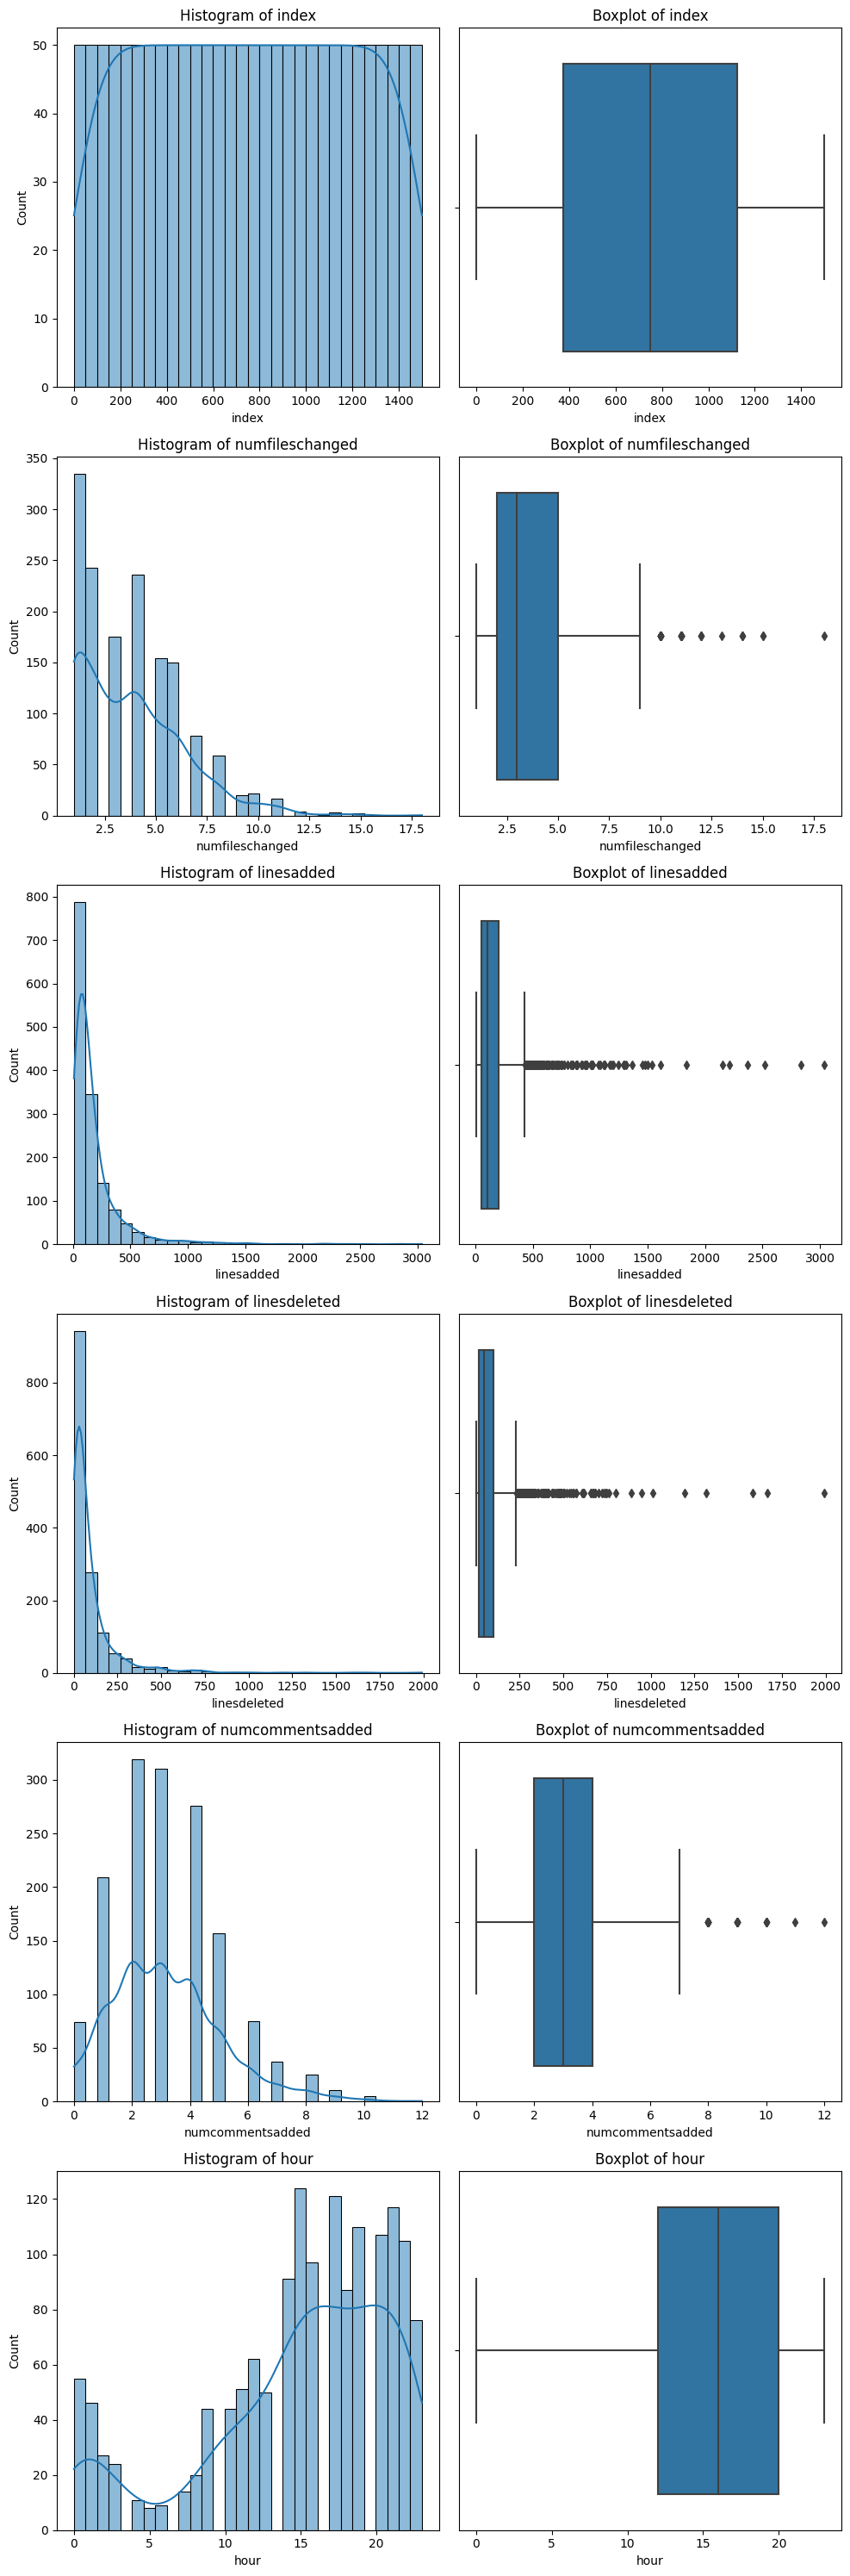

In [11]:
numerical_plots(data)  

<h2>Analysing above plots</h2>
<h4>We have so many outliers and very variable distribution, hence, scaling and outlier removal Would be 
usefull. But looking at the excess of outliers, removing all might lose some central points of data.

</h4>

In [12]:



#function to plot all the categorical columns
def plot_categorical_columns(df):
    
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    for col in cat_cols:
        # only plot if number of unique categories <= 10
        if df[col].nunique() <= 10:
            plt.figure(figsize=(6,4))
            sns.countplot(x=col, data=df, order=df[col].value_counts().index)
            plt.title(f"Countplot of {col}")
            plt.xticks(rotation=45)
            plt.show()



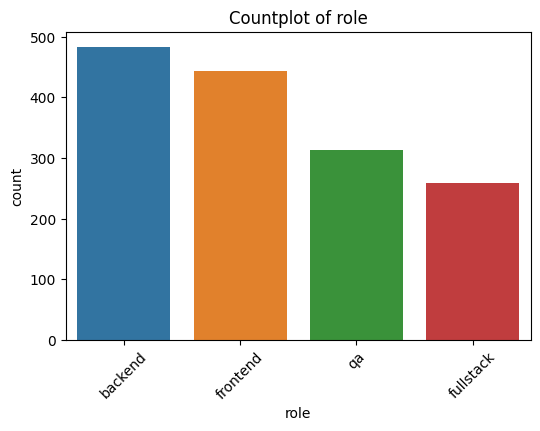

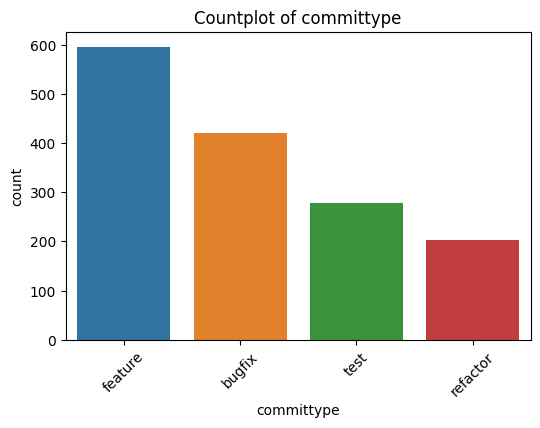

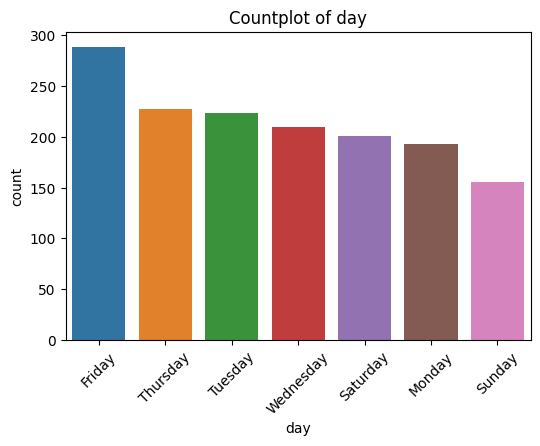

In [13]:
plot_categorical_columns(data)

<h1> Multivariate analysis</h1>

In [14]:
#understanding relations between numercial-numerial pairs



def scatter_plots(df):
    
    num_cols = df.select_dtypes(include='number').columns
    
   
    pairs = list(itertools.combinations(num_cols, 2))
    
    for col1, col2 in pairs:
        
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df[col1], y=df[col2], alpha=0.6)
        plt.title(f"Scatter Plot: {col1} vs {col2}")
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.show()



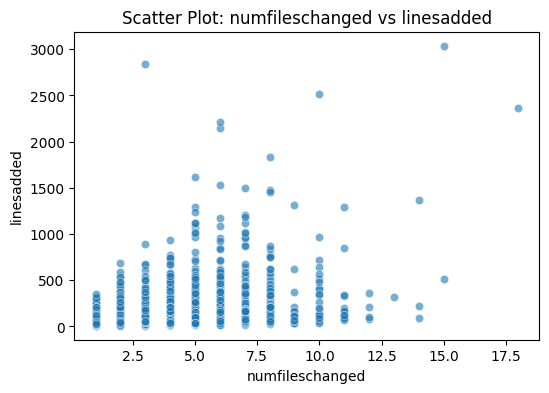

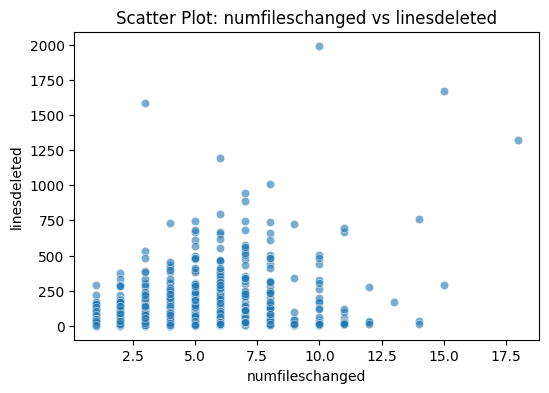

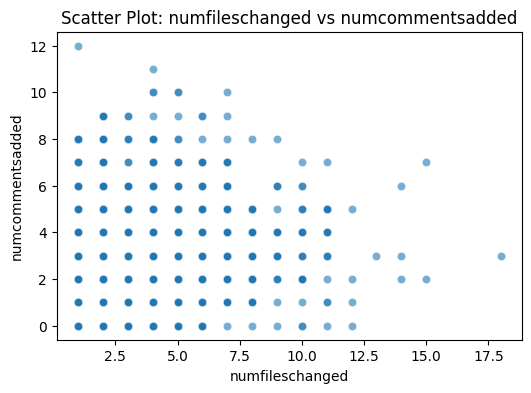

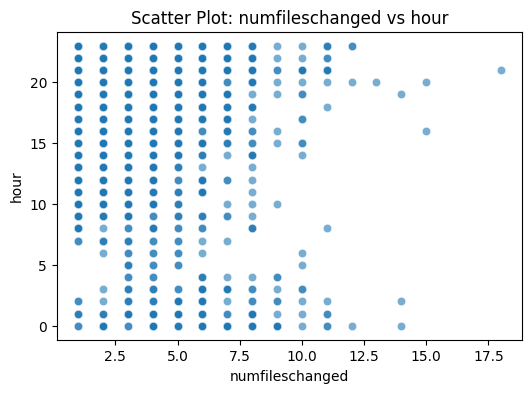

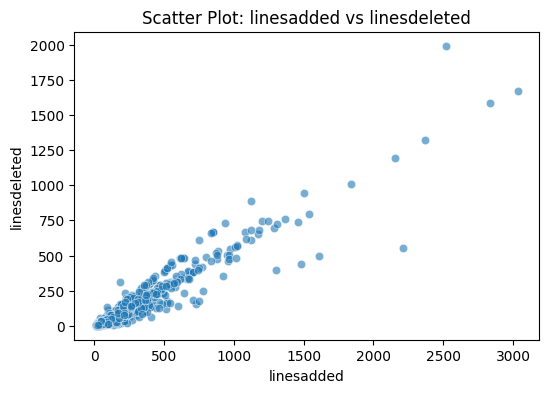

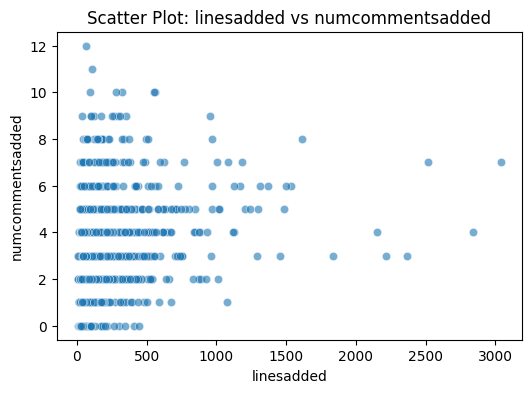

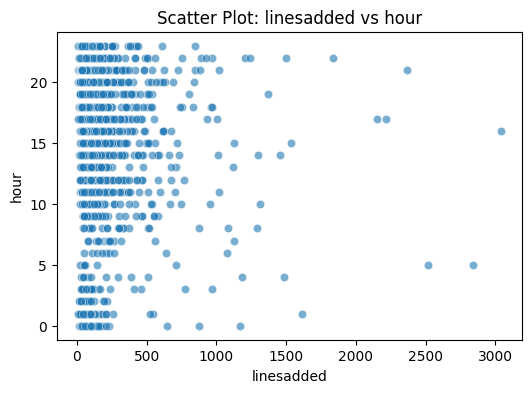

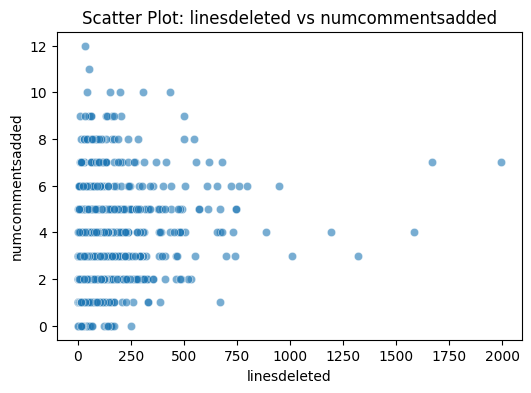

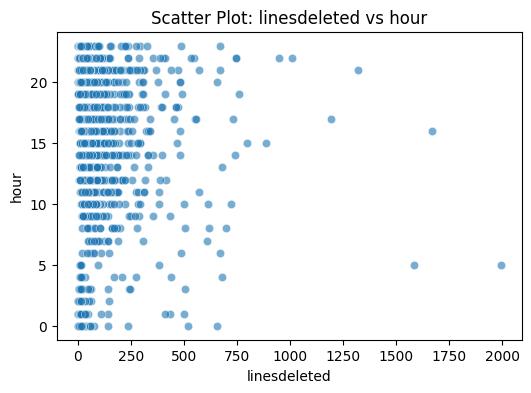

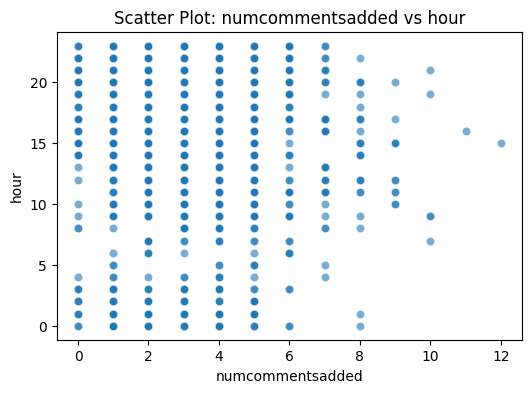

In [15]:
scatter_plots(data.drop("index", axis =1))

<h4> The above graphs show there is not interesting relations between numerical columns</h4>

<h2> Analysing the target column with respect to other numerical columns</h2>

In [16]:


# function to plot the kdeplot and boxplots between target and all other columns
def displots_and_boxplots_by_category(df, cat_col):
   
    if cat_col not in df.columns:
        print(f"Column '{cat_col}' not found in dataframe.")
        return
    if df[cat_col].dtype not in ['object', 'category']:
        print(f"Column '{cat_col}' is not categorical.")
        return
   
    num_cols = df.select_dtypes(include='number').columns
    
    fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, 5*len(num_cols)))
    
    for i, num in enumerate(num_cols):
     
        sns.kdeplot(data=df, x=num, hue=cat_col, fill=True, ax=axes[i,0])
        axes[i,0].set_title(f"Distribution of {num} by {cat_col}")
        
      
        sns.boxplot(x=cat_col, y=num, data=df, ax=axes[i,1])
        axes[i,1].set_title(f"Boxplot of {num} by {cat_col}")
        axes[i,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

   



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

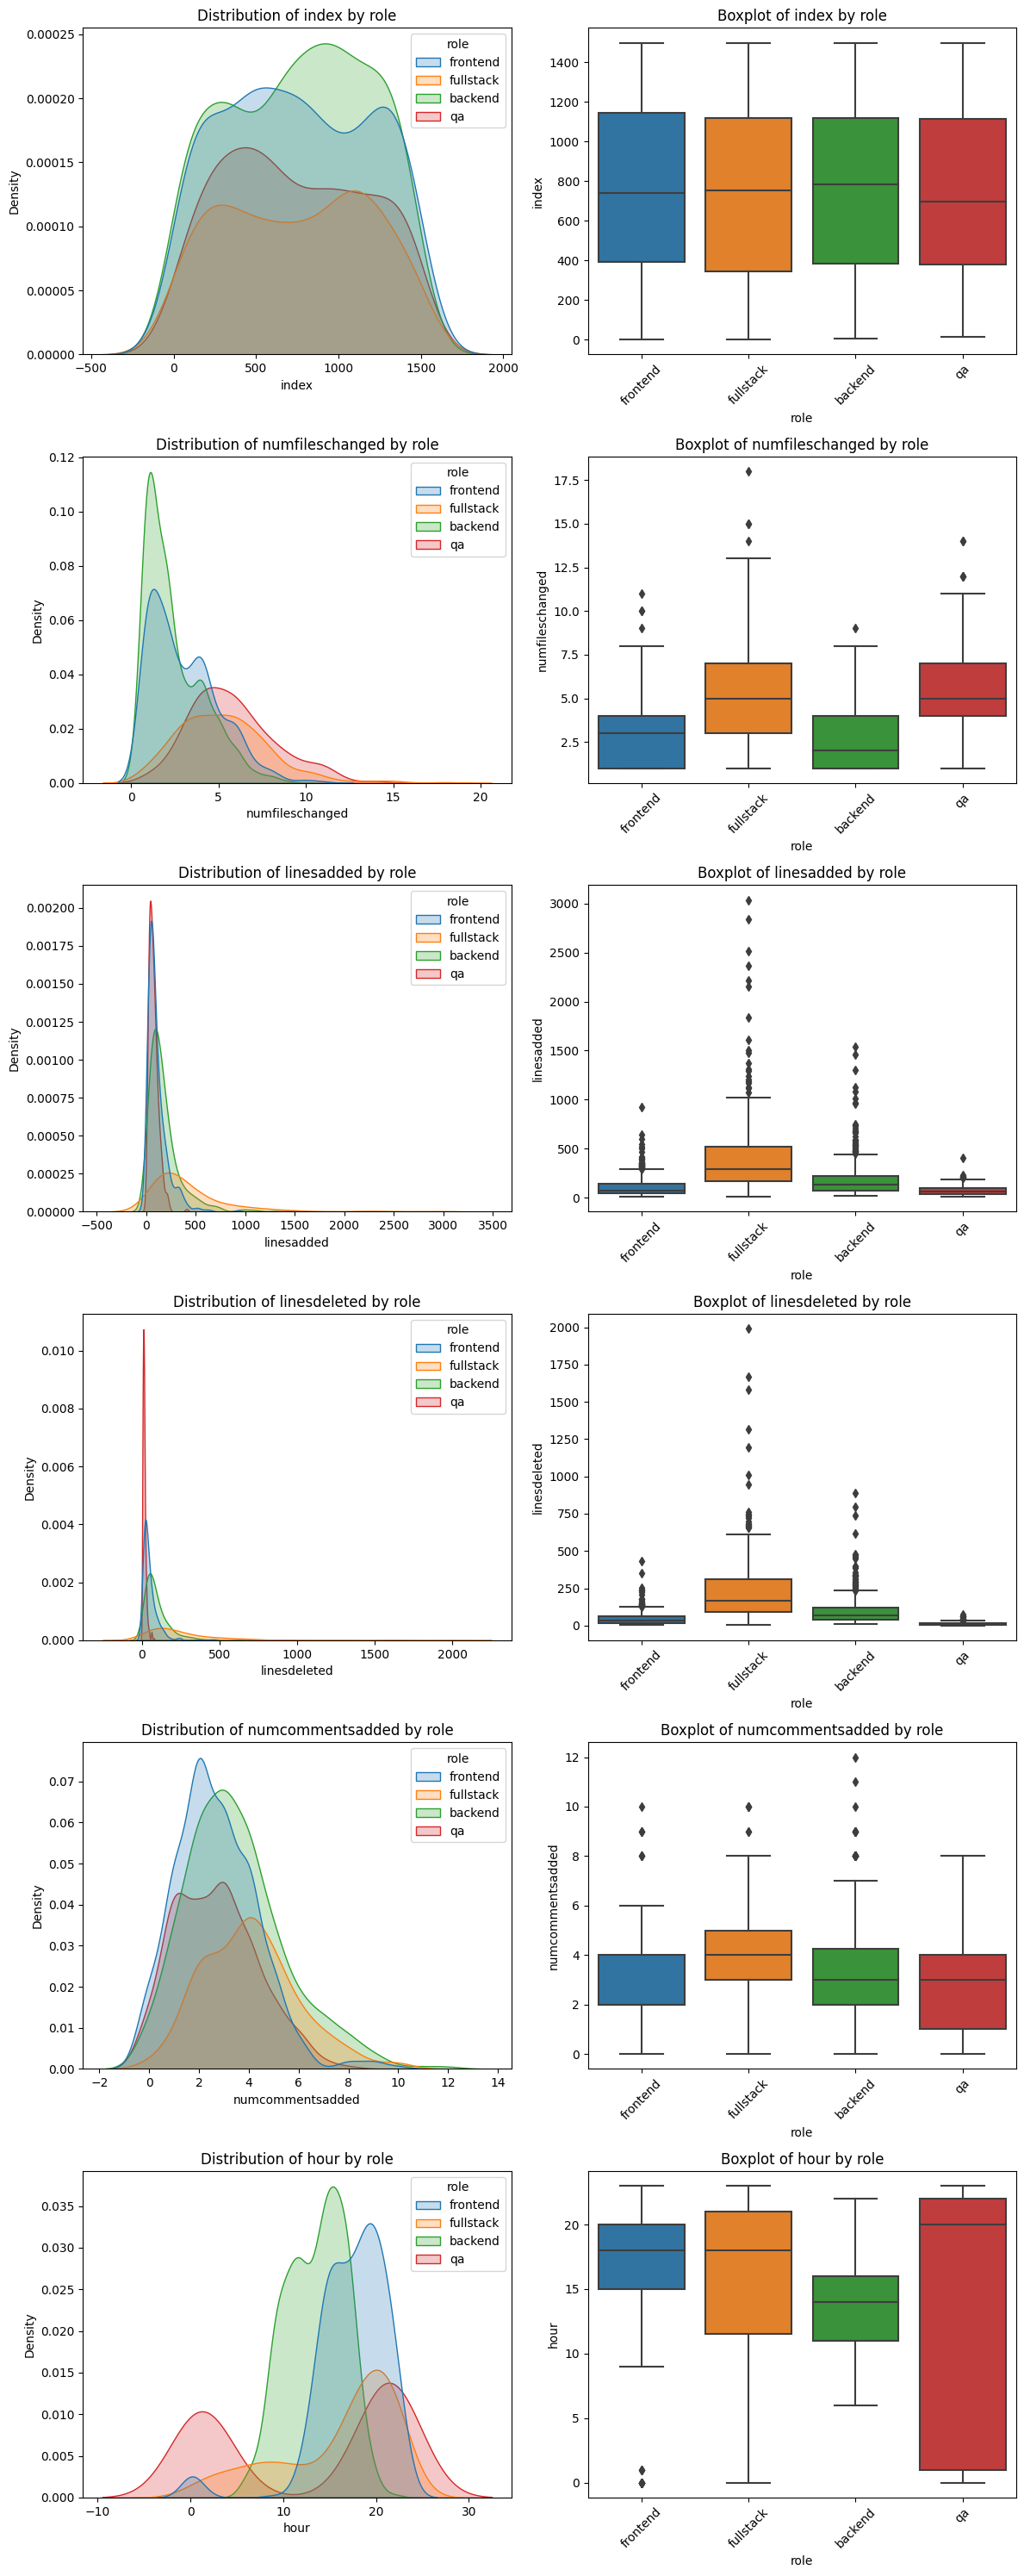

In [17]:
displots_and_boxplots_by_category(data, "role")

<h3> IMPORTANT TAKE AWAYS FROM ABOVE GRAPHS</h3>
<h4> We see that the output columns is depending robustly on the categorical columns
     except index. All other features even time is important

</h4>

<h3>CORRELATION AMOUNG THE NUMERICAL COLUMNS</h3
                                                >

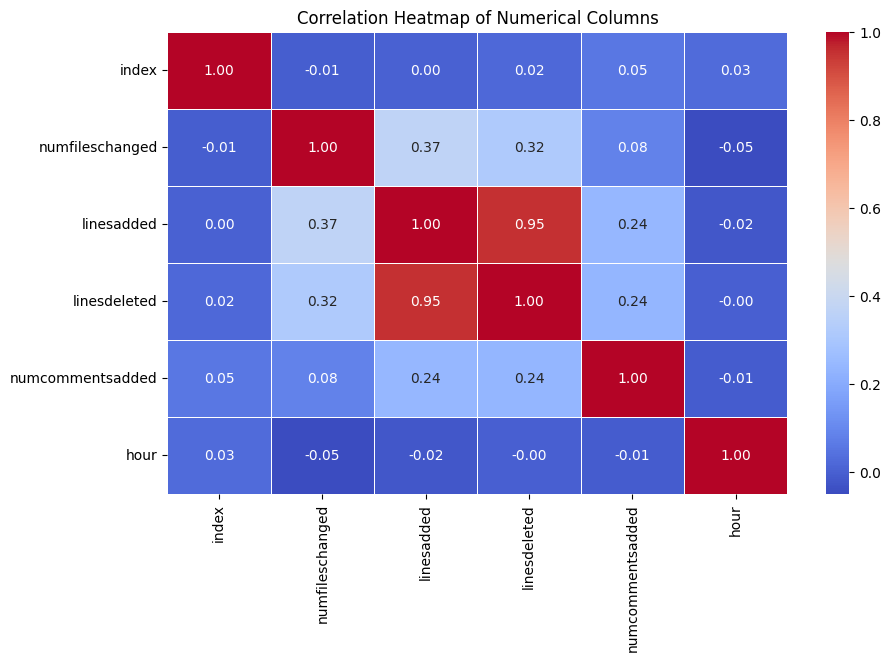

In [18]:



corr = data.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Columns")
plt.show()


<h2> Analysing the target columns with respect to other categorical columns(with <10 classes)</h2>

In [19]:


def analyze_categorical_relationships(df, target_col):
    
    if target_col not in df.columns:
        print(f"Column '{target_col}' not found in dataframe.")
        return
    
    
    if df[target_col].dtype not in ['object', 'category']:
        print(f"Column '{target_col}' is not categorical.")
        return
    
  
    cat_cols = [col for col in df.select_dtypes(include=['object', 'category']).columns 
                if col != target_col and df[col].nunique() <= 10]

    for col in cat_cols:
        print(f"\n📊 Analyzing: {target_col} vs {col}")
        
        # --- Crosstab ---
        cross = pd.crosstab(df[col], df[target_col])
        print("\nCrosstab:\n", cross)

        # --- Heatmap ---
        plt.figure(figsize=(6,4))
        sns.heatmap(cross, annot=True, fmt="d", cmap="Blues")
        plt.title(f"Heatmap: {col} vs {target_col}")
        plt.show()

        # --- Grouped Bar Plot ---
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, hue=target_col, data=df, palette="Set2")
        plt.title(f"Grouped Bar Plot: {col} vs {target_col}")
        plt.xticks(rotation=45)
        plt.show()




📊 Analyzing: role vs committype

Crosstab:
 role        backend  frontend  fullstack   qa
committype                                   
bugfix          197        78         87   59
feature         246       254         96    0
refactor         41       112         51    0
test              0         0         25  254


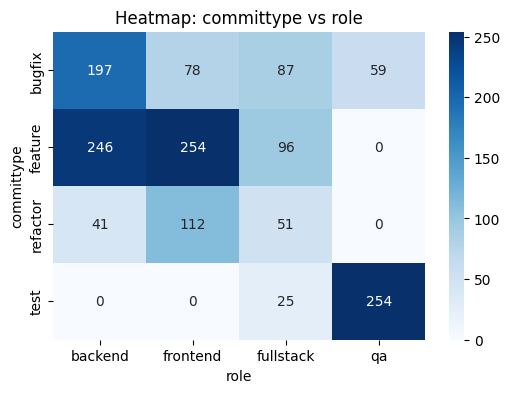

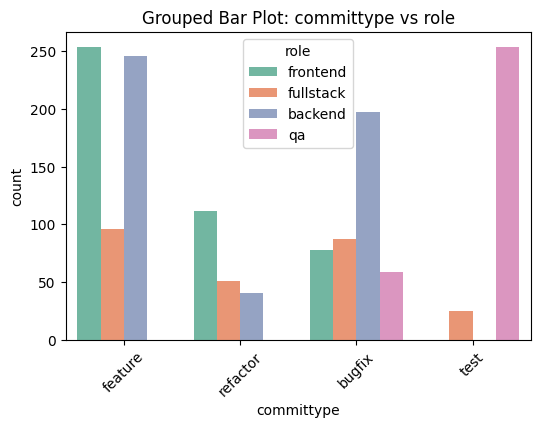


📊 Analyzing: role vs day

Crosstab:
 role       backend  frontend  fullstack  qa
day                                        
Friday          97        84         43  65
Monday          72        46         35  40
Saturday        37        63         52  49
Sunday          38        52         34  32
Thursday        69        71         30  57
Tuesday         90        60         38  36
Wednesday       81        68         27  34


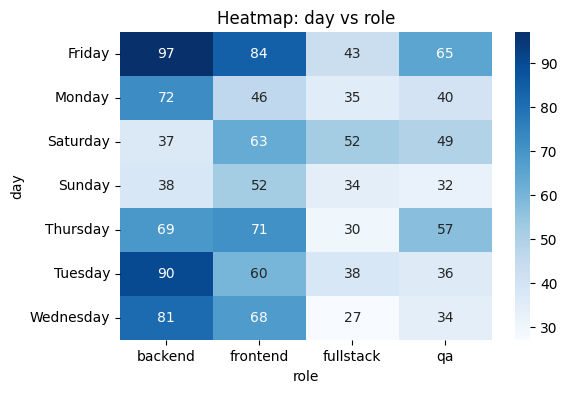

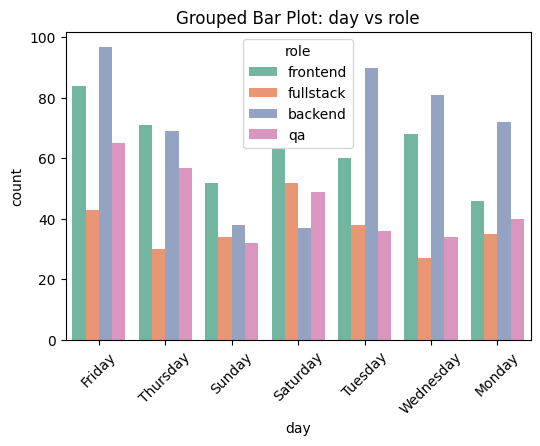

In [20]:
analyze_categorical_relationships(data, "role")

<h3> Above graphs again, shows that these columns are extremely important for role prediciton</h3>

<h2> Handling the file extensions columnm</h2>

In [21]:

#This would find out everything written in the bracket that is the extension name
data['fileextensions'] = data['fileextensions'].map(lambda x: re.findall(r'\((.*?)\)', x))

In [22]:
#this adds to the unique extension set to form new columns

cols = set();
for row in data['fileextensions']:
    for string in row:
        cols.add(string)
        

In [23]:
#lets make new columns to handle file extension
for col in cols:
    data[col ]   = data['fileextensions'].apply(lambda x: "YES" if col in x else "NO")

data = data.drop('fileextensions', axis =1)

In [24]:
y = data['role']
x = data.drop('role', axis = 1)

<h1> PREPROCESSING</h1>

<h3>train_test_split</h3>
<h4> Here we are splitting 20% data for test and rest for training</h4>

In [25]:



X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [26]:


#This function converts scales the numerical columns, add one hot encoding to categorical, and Apply Tfidf to 
#text

def preprocess_data(X_train, X_test, text_col, y_train, y_test):
    categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
    categorical_cols = [c for c in categorical_cols if X_train[c].nunique() < 10 and c != text_col]
    numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    transformer = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(sparse=False, drop='first'), categorical_cols),
            ('text', TfidfVectorizer(), text_col)
        ],
        remainder="passthrough"
    )
    
    X_train_arr = transformer.fit_transform(X_train)
    X_test_arr = transformer.transform(X_test)
    
    # Get feature names
    
    num_cols = numerical_cols
    cat_cols = transformer.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    text_cols = transformer.named_transformers_['text'].get_feature_names_out()
    
    # passthrough columns = everything not in numerical + categorical + text_col
    passthrough_cols = [c for c in X_train.columns if c not in numerical_cols + categorical_cols + [text_col]]
    
    all_cols = num_cols + list(cat_cols) + list(text_cols) + passthrough_cols
    
    # Convert to DataFrame
    X_train_processed = pd.DataFrame(
        X_train_arr.toarray() if hasattr(X_train_arr, "toarray") else X_train_arr,
        columns=all_cols,
        index=X_train.index
    )
    X_test_processed = pd.DataFrame(
        X_test_arr.toarray() if hasattr(X_test_arr, "toarray") else X_test_arr,
        columns=all_cols,
        index=X_test.index
    )
    le = LabelEncoder()
      
    y_train_pro= le.fit_transform(y_train);
    y_test_pro = le.transform(y_test)

    

    return X_train_processed, X_test_processed, y_train_pro, y_test_pro


In [27]:
X_train_, X_test_, y_train_, y_test_ = preprocess_data(X_train, X_test, "commitmessage", y_train, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<h1> Modelling</h1>

In [28]:

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}


<h2> Applying random forest</h2>

Accuracy: 0.97
Precision: 0.9728125
Recall: 0.97
F1 Score: 0.9694010712546665

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       0.91      1.00      0.95        87
           2       1.00      0.84      0.91        55
           3       1.00      1.00      1.00        72

    accuracy                           0.97       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.97      0.97      0.97       300



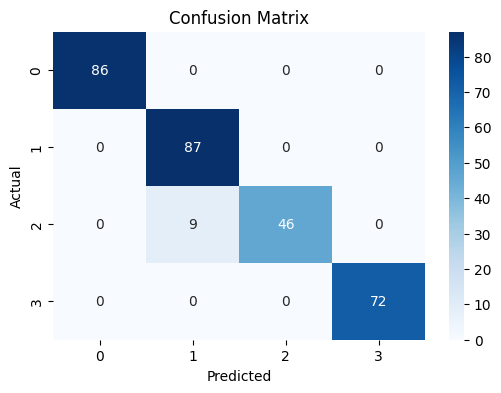

In [29]:



rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train_, y_train_)
y_pred = rf.predict(X_test_)

metrics_xgb = evaluate_model(rf, X_train_, y_train_, X_test_, y_test_)

<h2> Applying XgBoast</h2>

In [30]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import GridSearchCV

# xgb = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)


# param_grid = {
#     "n_estimators": [100, 200, 300],
#     "max_depth": [3, 5, 7],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "subsample": [0.8, 1.0],
#     "colsample_bytree": [0.8, 1.0]
# }


# grid = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     scoring="accuracy",  
#     cv=5,
#     verbose=1,
#     n_jobs=-1
# )


# grid.fit(X_train_, y_train_)


# print("Best Parameters:", grid.best_params_)
# print("Best CV Score:", grid.best_score_)


# best_xgb = grid.best_estimator_
# test_acc = best_xgb.score(X_test_, y_test_)
# print("Test Accuracy:", test_acc)


Accuracy: 0.9833333333333333
Precision: 0.98358547008547
Recall: 0.9833333333333333
F1 Score: 0.9832409314113735

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       0.96      0.99      0.97        87
           2       0.98      0.93      0.95        55
           3       1.00      1.00      1.00        72

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



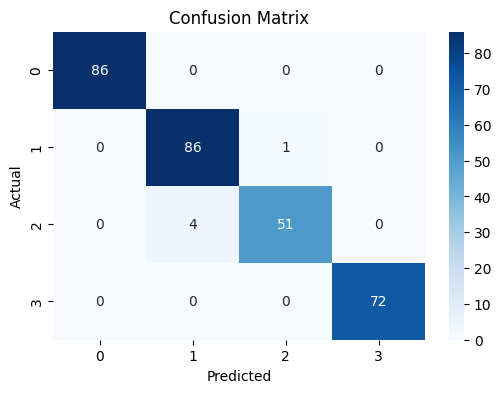

In [31]:



best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.2,
    'max_depth': 5,
    'n_estimators': 300,
    'subsample': 1.0
}

xgb_best = XGBClassifier(
    **best_params,
    objective="multi:softmax",  
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)


xgb_best.fit(X_train_, y_train_)


metrics_xgb = evaluate_model(xgb_best, X_train_, y_train_, X_test_, y_test_)


<h1> Deep learning based architects</h1>

<h2> Bislstms + embeddings</h2>

<h3> Basic preprocessing involving tokenization, scaling, and one hot encoding</h3>

In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preprocess_data(df, categorical_cols, numeric_cols, text_col, max_words=10000, max_len=100, test_size=0.2):
    # train-test split
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=42)

    # --- categorical ---
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
    X_train_cat = ohe.fit_transform(train_df[categorical_cols])
    X_val_cat = ohe.transform(val_df[categorical_cols])

    # --- numerical ---
    scaler = StandardScaler()
    X_train_num = scaler.fit_transform(train_df[numeric_cols])
    X_val_num = scaler.transform(val_df[numeric_cols])

    # --- text ---
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(train_df[text_col])

    X_train_text = tokenizer.texts_to_sequences(train_df[text_col])
    X_val_text = tokenizer.texts_to_sequences(val_df[text_col])

    X_train_text = pad_sequences(X_train_text, maxlen=max_len, padding="post")
    X_val_text = pad_sequences(X_val_text, maxlen=max_len, padding="post")

    # --- merge numerical + categorical ---
    X_train_numcat = np.hstack([X_train_num, X_train_cat])
    X_val_numcat = np.hstack([X_val_num, X_val_cat])

    return (X_train_numcat, X_val_numcat, 
            X_train_text, X_val_text, 
            tokenizer.word_index, len(tokenizer.word_index) + 1, 
            train_df, val_df)

    

<h2> Model architect: 
   input = combined emeddings for numerical + columns + the text passed through Bidirectional LSTMS
    
</h2>

In [33]:
from tensorflow.keras.layers import Input, Dense, Embedding, Bidirectional, LSTM, Dropout, Concatenate
from tensorflow.keras.models import Model

def build_model(vocab_size, max_len, num_numcat_features, output_dim, embedding_dim=128, lstm_units=64, dropout_rate=0.3):

    text_input = Input(shape=(max_len,), name="text_input")
    x = Embedding(vocab_size, embedding_dim, input_length=max_len)(text_input)
    x = Bidirectional(LSTM(lstm_units))(x)
    x = Dropout(dropout_rate)(x)


    numcat_input = Input(shape=(num_numcat_features,), name="numcat_input")
    y = Dense(64, activation="relu")(numcat_input)
    y = Dropout(dropout_rate)(y)


    merged = Concatenate()([x, y])
    z = Dense(64, activation="relu")(merged)
    z = Dropout(dropout_rate)(z)

    
    if output_dim == 1:   
        output = Dense(1, activation="sigmoid")(z)
    else:                
        output = Dense(output_dim, activation="softmax")(z)

    model = Model(inputs=[text_input, numcat_input], outputs=output)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy" if output_dim == 1 else "sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


<h3> Writing the training loop</h3>

In [34]:
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint

numeric_cols = [
    "numfileschanged", "linesadded", "linesdeleted", 
    "numcommentsadded", "hour"
]

categorical_cols = [
    "committype", "'css'", "'test_js'", "'js_ts'", "'java_go'",
    "'py'", "'md'", "'sql'", "'yml_json'", "'html'", "'test_py'", "day"
]

text_col = "commitmessage"
target_col = "role"

X_train_numcat, X_val_numcat, X_train_text, X_val_text, word_index, vocab_size, train_df, val_df = preprocess_data(
    data, categorical_cols, numeric_cols, text_col, max_words=10000, max_len=100
)

y_train, y_val = train_df[target_col].values, val_df[target_col].values


le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val   = le.transform(y_val)


num_numcat_features = X_train_numcat.shape[1]
output_dim = len(np.unique(y_train)) 
model = build_model(vocab_size, max_len=100, num_numcat_features=num_numcat_features, output_dim=output_dim)

checkpoint = ModelCheckpoint(
    filepath="checkpoint_epoch_{epoch:02d}.keras",   
    save_freq="epoch",                              
    save_weights_only=False,                         
)
history = model.fit(
    [X_train_text, X_train_numcat], y_train,
    validation_data=([X_val_text, X_val_numcat], y_val),
    epochs=20, batch_size=32, callbacks=[checkpoint]
)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-09-03 04:43:42.148769: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.4250 - loss: 1.2232 - val_accuracy: 0.9033 - val_loss: 0.3147
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9089 - loss: 0.2857 - val_accuracy: 0.9667 - val_loss: 0.1028
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9682 - loss: 0.1069 - val_accuracy: 0.9633 - val_loss: 0.1081
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9758 - loss: 0.0770 - val_accuracy: 0.9767 - val_loss: 0.0658
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9848 - loss: 0.0591 - val_accuracy: 0.9700 - val_loss: 0.1041
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.9834 - loss: 0.0497 - val_accuracy: 0.9700 - val_loss: 0.0847
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.9849 - loss: 0.0479 - val_accuracy: 0.9700 - val_loss: 0.0935
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9906 - loss: 0.0355 - val_accuracy: 0.9633 - 

In [35]:
from keras.models import load_model
model_epoch = load_model("checkpoint_epoch_20.keras")


<h2> Lets evaluate the model</h2>

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model_deep(model_, X_test, y_test, label_encoder, save_path="confusion_matrix.png"):
    # predictions
    y_pred_prob = model_.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted")
    rec = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)
    
    # classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    
    # save confusion matrix
    plt.savefig(save_path, bbox_inches="tight", dpi=300)
    plt.show()
    
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "y_pred":y_pred
    }


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.9733333333333334
Precision: 0.975578947368421
Recall: 0.9733333333333334
F1 Score: 0.9731148786488591

Classification Report:
              precision    recall  f1-score   support

     backend       1.00      1.00      1.00        86
    frontend       0.92      1.00      0.96        87
   fullstack       1.00      0.87      0.93        55
          qa       1.00      0.99      0.99        72

    accuracy                           0.97       300
   macro avg       0.98      0.96      0.97       300
weighted avg       0.98      0.97      0.97       300



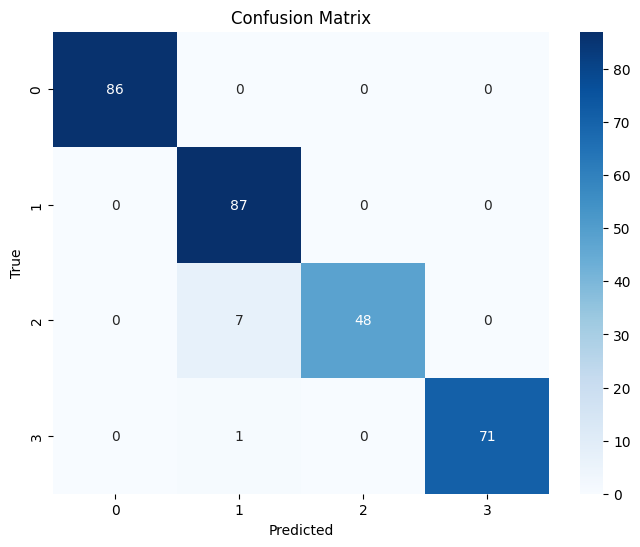

In [37]:
evaluation = evaluate_model_deep(model_epoch,[X_val_text, X_val_numcat], y_val, le) 